## EXPERIMENT 2.2: AdaFace

In [7]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *


from IPython import embed


In [8]:
# Save figures
from matplotlib import pyplot as plt
save_fig_path = '../../figures/ada_2_2/'


### AdaFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

In [9]:
feature_list_children = '../../data/data_full/feature_vectors/adaface_feature_vectors/2.2/similarity_scores_children_bibel_FINAL_INFERENCE_finetuning_2_2.pt'
feature_list_adults = '../../data/data_full/feature_vectors/adaface_feature_vectors/2.2/similarity_scores_adults_retina_bibel_FINAL_INFERENCE_finetuning_2_2.pt'


image_names_c, ids_c, num_ids_c, norm_feats_c = load_adaface_vectors(feature_list_children)
image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors(feature_list_adults)
# image_names_a, ids_a, num_ids_a, norm_feats_a = load_adaface_vectors_adults(feature_list_adults) # virker for den gamle, men ikke de cropped af en eller anden grund

ids_a = ["_".join(x.split("_")[1:]) for x in ids_a]


# Similarity matrices from adaface - all
sim_mat_c = np.dot(norm_feats_c, norm_feats_c.T)
sim_mat_a = np.dot(norm_feats_a, norm_feats_a.T)


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

# Finding the right threshold

In [6]:
# def compute_metrics_ex_1_1(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE):
#     FNIR_c_list = []
#     FNIR_a_list = []
#     FPIR_c_list = []
#     FPIR_a_list = []
#     FPD_list = []
#     FND_list = []
#     GARBE_list = []
#     threshold_list = []

#     for random_state_i in random_states:
#         # Load children and adults balanced data
#         children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
#         adults_balanced_df_i = balance_adults_data_enrolled(children_balanced_df_i, adults_all, print_stats=False, random_state=random_state_i)

#         # All reference image names, enrolled and non-enrolled image names - children
#         c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
#         enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
#         enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
#         non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
#         non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
#         all_reference_image_names_c = list(children_balanced_df_i.image_name)

#         # All reference image names, enrolled and non-enrolled image names - adults
#         a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
#         enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
#         enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
#         non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
#         non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
#         all_reference_image_names_a = list(adults_balanced_df_i.image_name)

#         # Debugging Step: Print the dimensions of sim_mat_c
#         print(f"sim_mat_c shape: {sim_mat_c.shape}")

#         # Similarity matrices for ids in reference database
#         indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c if image_names_c.index(name) < sim_mat_c.shape[1]]
#         indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a if image_names_a.index(name) < sim_mat_a.shape[1]]

#         # Debugging Step: Check indices_c_all_reference
#         print(f"indices_c_all_reference: {indices_c_all_reference}")
#         print(f"Number of image names in children: {len(image_names_c)}")
#         print(f"Maximum index in indices_c_all_reference: {max(indices_c_all_reference)}")

#         # Extract corresponding columns from the similarity matrix
#         sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]
#         sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

#         # Extract corresponding rows from the numerical ids
#         num_ids_c_reference = num_ids_c[indices_c_all_reference]
#         num_ids_a_reference = num_ids_a[indices_a_all_reference]

#         # Similarity matrices for non-enrolled ids
#         indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c if image_names_c.index(name) < sim_mat_c.shape[0]]
#         indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a if image_names_a.index(name) < sim_mat_a.shape[0]]

#         sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
#         sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

#         num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
#         num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]

#         # Similarity matrices for enrolled ids
#         indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c if image_names_c.index(name) < sim_mat_c.shape[0]]
#         indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a if image_names_a.index(name) < sim_mat_a.shape[0]]

#         sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)]
#         sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

#         num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
#         num_ids_a_enrolled = num_ids_a[indices_a_enrolled]

#         for percentile in percentiles:
#             # thold = (np.percentile(sim_mat_c, percentile) + np.percentile(sim_mat_a, percentile)) / 2
#             thold = percentile

#             # Evaluation metrics
#             FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=thold)
#             FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=thold)

#             FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=thold)
#             FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=thold)

#             alpha_garbe = 0.25
#             FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)

#             FNIR_c_list.append(FNIR_c)
#             FNIR_a_list.append(FNIR_a)
#             FPIR_c_list.append(FPIR_c)
#             FPIR_a_list.append(FPIR_a)
#             FPD_list.append(FPD_i)
#             FND_list.append(FND_i)
#             GARBE_list.append(GARBE_i)
#             threshold_list.append(thold)

#             print(f"Done for random_state: {random_state_i}, percentile: {percentile}")

#     data = {
#         'Iteration': np.repeat(random_states, len(percentiles)),
#         'Percentile': percentiles * len(random_states),
#         'FNIR_c': FNIR_c_list,
#         'FNIR_a': FNIR_a_list,
#         'FPIR_c': FPIR_c_list,
#         'FPIR_a': FPIR_a_list,
#         'FPD': FPD_list,
#         'FND': FND_list,
#         'GARBE': GARBE_list,
#         'Threshold': threshold_list
#     }

#     df_all_threshold_x = pd.DataFrame(data)

#     return df_all_threshold_x


In [5]:
random_states = [1,2]
percentiles = np.arange(0.0, 1.0, 0.01).tolist()

df_all_threshold_x = compute_metrics_ex_1_1(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.31025529129391227
GARBE result, GARBE close to 1 means more unfair:  0.2326914684704342
Done for random_state: 1, percentile: 0.0
FPD result:  0.0
FND result:  0.36049347065806786
GARBE result, GARBE close to 1 means more unfair:  0.2703701029935509
Done for random_state: 1, percentile: 0.01
FPD result:  0.0
FND result:  0.2551457130789807
GARBE result, GARBE close to 1 means more unfair:  0.19135928480923553
Done for random_state: 1, percentile: 0.02
FPD result:  0.0
FND result:  0.26858800361913887
GARBE result, GARBE close to 1 means more unfair:  0.20144100271435417
Done for random_state: 1, percentile: 0.03
FPD result:  0.0
FND result:  0.26858800361913887
GARBE result, GARBE close to 1 means more unfair:  0.20144100271435417
Done for random_state: 1, percentile: 0.04
FPD result:  0.0
FND result:  0.19738909105370953
GARBE result, GARBE close to 1 means more unfair:  0.14804181829028215
Done for random_state: 1, percentile: 0.05
FPD result:  0.0
FND

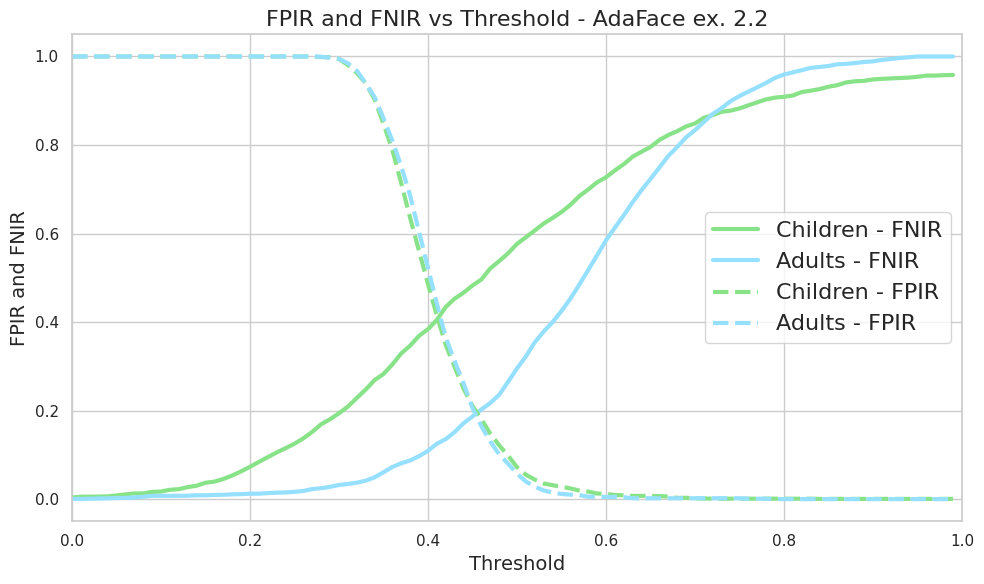

In [6]:

# plot_threshold_metrics_ex_1_1_together(df_all_threshold_x, 'AdaFace')
plot_threshold_metrics_ex_1_1_together(df_all_threshold_x, 'AdaFace ex. 2.2', save_fig_path)

In [8]:
def plot_threshold_metrics_ex_1_2_zoomed(df_all_threshold_x):
    # Set the aesthetics for the plots
    sns.set(style="whitegrid")

    plot_df = df_all_threshold_x.groupby('Threshold').mean()

    plt.figure(figsize=(14, 7))
    plt.plot(plot_df.index, plot_df['FNIR_c'], 'r-', label='Canonical - children - FNIR',linewidth=3.0)
    plt.plot(plot_df.index, plot_df['FNIR_a'], 'c-', label='Mixed quality - children - FNIR',linewidth=3.0)
    plt.xlabel('Threshold', fontsize=20)
    plt.ylabel('FNIR and FPIR', fontsize=20)
    plt.title('FNIR vs Threshold', fontsize=20)
    plt.ylim(0.0, 0.07)  # Limit the FNIR y-axis
    plt.xlim(0.15, 0.2)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()


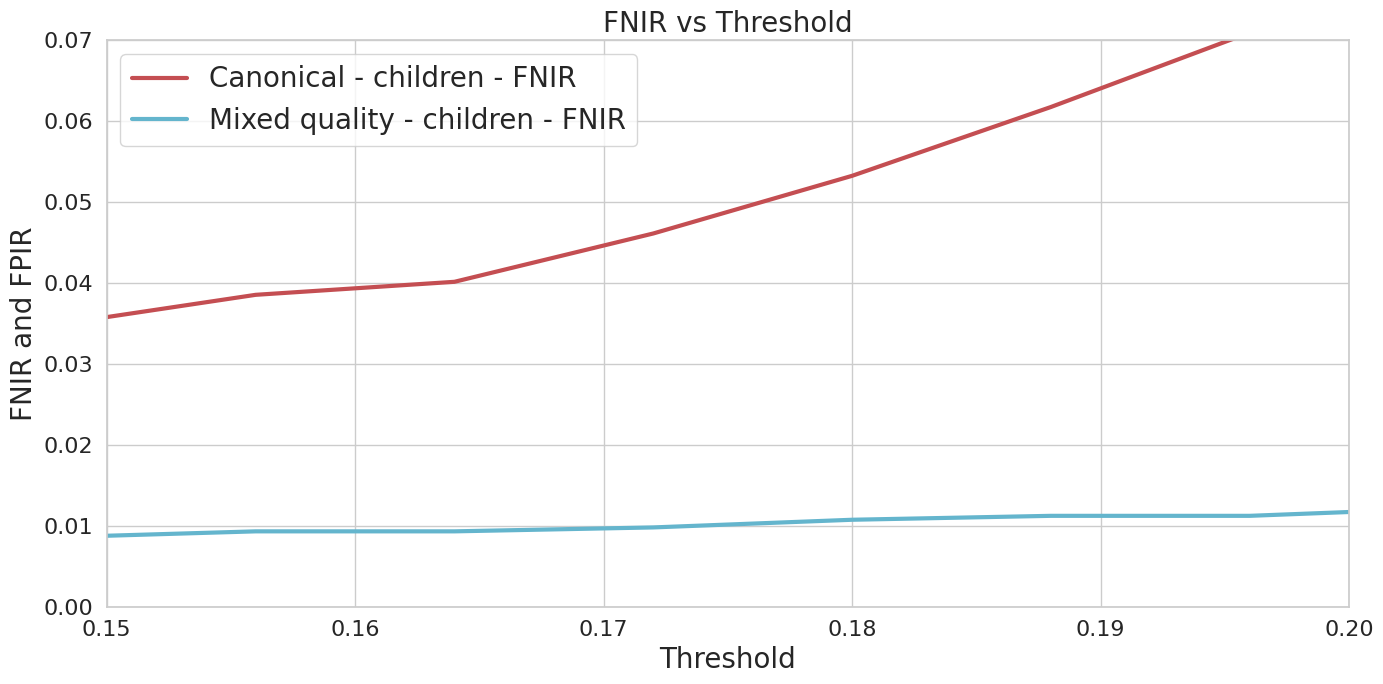

In [9]:
plot_threshold_metrics_ex_1_2_zoomed(df_all_threshold_x)

# then the threshold should be based on the childrens and that would be 0.177

# Stats

In [11]:
# def evaluate_metrics_ex_1_1(random_states, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, threshold_number, alpha_garbe=0.25):
#     sim_mat_dict_all = {}
#     FNIR_c_list = []
#     FNIR_a_list = []
#     FPIR_c_list = []
#     FPIR_a_list = []
#     FPD_list = []
#     FND_list = []
#     GARBE_list = []
#     threshold_list = []

#     for random_state_i in random_states:
#         ### Load children and adults balanced data ###
#         children_balanced_df_i = balance_child_data(children_all, print_stats=False, random_state=random_state_i)
#         adults_balanced_df_i = balance_adults_data_enrolled(children_balanced_df_i, adults_all, print_stats=False, random_state=random_state_i)

#         ### All reference image names, enrolled and non-enrolled image names - children ###
#         c_mates = children_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
#         enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] > 1].index
#         enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(enrolled_identity_names_c)].image_name)
#         non_enrolled_identity_names_c = c_mates[c_mates[('identity_name', 'count')] == 1].index
#         non_enrolled_image_names_c = list(children_balanced_df_i[children_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_c)].image_name)
#         all_reference_image_names_c = list(children_balanced_df_i.image_name)

#         ### All reference image names, enrolled and non-enrolled image names - adults ###
#         a_mates = adults_balanced_df_i.groupby("identity_name").agg({'identity_name': ['count']})
#         enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] > 1].index
#         enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(enrolled_identity_names_a)].image_name)
#         non_enrolled_identity_names_a = a_mates[a_mates[('identity_name', 'count')] == 1].index
#         non_enrolled_image_names_a = list(adults_balanced_df_i[adults_balanced_df_i["identity_name"].isin(non_enrolled_identity_names_a)].image_name)
#         all_reference_image_names_a = list(adults_balanced_df_i.image_name)

#         ### Similarity matrices for ids in reference database ###
#         indices_c_all_reference = [image_names_c.index(name) for name in all_reference_image_names_c if image_names_c.index(name) < sim_mat_c.shape[1]]
#         indices_a_all_reference = [image_names_a.index(name) for name in all_reference_image_names_a if image_names_a.index(name) < sim_mat_a.shape[1]]

#         # Extract corresponding columns from the similarity matrix
#         sim_mat_c_reference_cols = sim_mat_c[:, indices_c_all_reference]
#         sim_mat_a_reference_cols = sim_mat_a[:, indices_a_all_reference]

#         # Extract corresponding rows from the numerical ids
#         num_ids_c_reference = num_ids_c[indices_c_all_reference]
#         num_ids_a_reference = num_ids_a[indices_a_all_reference]

#         ### Similarity matrices for non-enrolled ids ###
#         indices_c_non_enrolled = [image_names_c.index(name) for name in non_enrolled_image_names_c if image_names_c.index(name) < sim_mat_c.shape[0]]
#         indices_a_non_enrolled = [image_names_a.index(name) for name in non_enrolled_image_names_a if image_names_a.index(name) < sim_mat_a.shape[0]]

#         sim_mat_c_non_enrolled_0 = sim_mat_c_reference_cols[indices_c_non_enrolled]
#         sim_mat_a_non_enrolled_0 = sim_mat_a_reference_cols[indices_a_non_enrolled]

#         num_ids_c_non_enrolled = num_ids_c[indices_c_non_enrolled]
#         num_ids_a_non_enrolled = num_ids_a[indices_a_non_enrolled]

#         ### Similarity matrices for enrolled ids ###
#         indices_c_enrolled = [image_names_c.index(name) for name in enrolled_image_names_c if image_names_c.index(name) < sim_mat_c.shape[0]]
#         indices_a_enrolled = [image_names_a.index(name) for name in enrolled_image_names_a if image_names_a.index(name) < sim_mat_a.shape[0]]

#         sim_mat_c_enrolled_0 = sim_mat_c[np.ix_(indices_c_enrolled, indices_c_enrolled)]
#         sim_mat_a_enrolled_0 = sim_mat_a[np.ix_(indices_a_enrolled, indices_a_enrolled)]

#         num_ids_c_enrolled = num_ids_c[indices_c_enrolled]
#         num_ids_a_enrolled = num_ids_a[indices_a_enrolled]

#         thold = threshold_number

#         ### Evaluation metrics ###
#         # FNIR
#         FNIR_c, sim_mat_c_enrolled = compute_fnir(sim_mat_c_enrolled_0, sim_mat_c, enrolled_identity_names_c, num_ids_c_enrolled, ids_c, thold=threshold_number)
#         FNIR_a, sim_mat_a_enrolled = compute_fnir(sim_mat_a_enrolled_0, sim_mat_a, enrolled_identity_names_a, num_ids_a_enrolled, ids_a, thold=threshold_number)
#         # FPIR
#         FPIR_c = compute_fpir(sim_mat_c_non_enrolled_0, num_ids_c_non_enrolled, num_ids_c_reference, thold=threshold_number)
#         FPIR_a = compute_fpir(sim_mat_a_non_enrolled_0, num_ids_a_non_enrolled, num_ids_a_reference, thold=threshold_number)

#         FPD_i, FND_i, GARBE_i = GARBE(FNIR_c, FNIR_a, FPIR_c, FPIR_a, alpha=alpha_garbe)

#         FNIR_c_list.append(FNIR_c)
#         FNIR_a_list.append(FNIR_a)
#         FPIR_c_list.append(FPIR_c)
#         FPIR_a_list.append(FPIR_a)
#         FPD_list.append(FPD_i)
#         FND_list.append(FND_i)
#         GARBE_list.append(GARBE_i)
#         threshold_list.append(thold)

#         sim_mat_dict_all[f'sim_mat_c_enrolled_iteration_{random_state_i}'] = sim_mat_c_enrolled
#         sim_mat_dict_all[f'sim_mat_a_enrolled_iteration_{random_state_i}'] = sim_mat_a_enrolled
#         sim_mat_dict_all[f'sim_mat_c_non_enrolled_iteration_{random_state_i}'] = remove_ones(sim_mat_c_non_enrolled_0)
#         sim_mat_dict_all[f'sim_mat_a_non_enrolled_iteration_{random_state_i}'] = remove_ones(sim_mat_a_non_enrolled_0)

#         print("done")

#     data = {
#         'Iteration': random_states,
#         'FNIR_c': FNIR_c_list,
#         'FNIR_a': FNIR_a_list,
#         'FPIR_c': FPIR_c_list,
#         'FPIR_a': FPIR_a_list,
#         'FPD': FPD_list,
#         'FND': FND_list,
#         'GARBE': GARBE_list,
#         'Threshold': threshold_list
#         }
#     df_all_results = pd.DataFrame(data)
#     return df_all_results, sim_mat_dict_all


In [10]:

random_states = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

df_all_results, sim_mat_dict_all_magface_ex1_1 = evaluate_metrics_ex_1_1(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
)

df_all_results.describe().applymap(lambda x: f"{x:.3f}")

FPD result:  0.0
FND result:  0.29148283138308073
GARBE result, GARBE close to 1 means more unfair:  0.21861212353731055
done
FPD result:  0.0
FND result:  0.3857217710243647
GARBE result, GARBE close to 1 means more unfair:  0.28929132826827353
done
FPD result:  0.0
FND result:  0.34121589937384494
GARBE result, GARBE close to 1 means more unfair:  0.2559119245303837
done
FPD result:  0.0
FND result:  0.2677471412485172
GARBE result, GARBE close to 1 means more unfair:  0.20081035593638788
done
FPD result:  0.0
FND result:  0.37359387684100653
GARBE result, GARBE close to 1 means more unfair:  0.2801954076307549
done
FPD result:  0.0
FND result:  0.274481165768475
GARBE result, GARBE close to 1 means more unfair:  0.20586087432635625
done
FPD result:  0.0
FND result:  0.339948342660353
GARBE result, GARBE close to 1 means more unfair:  0.25496125699526473
done
FPD result:  0.0
FND result:  0.3910638467518488
GARBE result, GARBE close to 1 means more unfair:  0.2932978850638866
done
FP

/tmp/ipykernel_87639/1290186671.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,5.500,0.054,0.011,1.000,1.000,0.000,0.337,0.253,0.177
std,3.028,0.006,0.004,0.000,0.000,0.000,0.045,0.034,0.000
min,1.000,0.041,0.006,1.000,1.000,0.000,0.268,0.201,0.177
25%,3.250,0.052,0.007,1.000,1.000,0.000,0.302,0.227,0.177
50%,5.500,0.054,0.010,1.000,1.000,0.000,0.341,0.255,0.177
75%,7.750,0.057,0.013,1.000,1.000,0.000,0.373,0.280,0.177
max,10.000,0.063,0.017,1.000,1.000,0.000,0.391,0.293,0.177


In [ ]:
# Generate the LaTeX table
latex_table = generate_latex_table(df_all_results.applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)


In [ ]:
latex_table = generate_latex_table(df_all_results.describe().applymap(lambda x: f"{x:.3f}").drop(columns='Iteration'))
print(latex_table)

# Gemmer simscores

In [12]:

sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_ada_2_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))

sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_ada_2_2.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))

sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_ada_2_2.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(1, 11):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_ada_2_2.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


121238
41438


32751054
32371232


# loader sim scores

In [14]:
sim_mat_c_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_c_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_a_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_ada_2_2.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all_ada = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_ada_2_2.csv')).values.flatten()


In [15]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [16]:
mated_scores1 = sim_mat_a_enrolled_iterations_all_ada
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all_ada
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,41438.000000,3.237123e+07
1,Minimum,-0.089405,-3.548896e-01
2,Maximum,0.966777,8.284518e-01
3,Mean,0.601085,7.821493e-02
4,St. Dev.,0.136917,8.474605e-02
5,Skewness,-0.438430,2.679493e-01
6,Ex. Kurtosis,1.036691,3.769982e-01


In [17]:
mated_scores2 = sim_mat_c_enrolled_iterations_all_ada
nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all_ada
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,121238.000000,3.275105e+07
1,Minimum,-0.125532,-4.022020e-01
2,Maximum,0.997537,9.999274e-01
3,Mean,0.490542,4.664561e-02
4,St. Dev.,0.180870,9.323633e-02
5,Skewness,0.045564,2.218874e-01
6,Ex. Kurtosis,-0.323861,1.823066e-01


In [18]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 12
label_fontsize = 16

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

In [19]:

# import matplotlib.pyplot as plt
# import numpy as np

# def plot_histogram(mated_scores, nonmated_scores, normalise=True, savename=None, title="Histogram"):
#     def normalise_scores(distribution):
#         return np.ones_like(distribution) / len(distribution)

#     mated_mean = np.mean(mated_scores)

#     plt.figure(figsize=(10, 6))  # Replace 'figure_size' with a specific size if not defined

#     if normalise:
#         plt.hist(mated_scores, bins=50, weights=normalise_scores(mated_scores), color='green', alpha=0.5, label='Mated Scores')  # Replace 'mated_label' with 'Mated Scores'
#         plt.hist(nonmated_scores, bins=30, weights=normalise_scores(nonmated_scores), color='red', alpha=0.5, label='Non-mated Scores')  # Replace 'nonmated_label' with 'Non-mated Scores'
#         ylabel = "Probability Density"
#     else:
#         plt.hist(mated_scores, bins=50, color='green', alpha=0.5, label='Mated Scores')
#         plt.hist(nonmated_scores, bins=30, color='red', alpha=0.5, label='Non-mated Scores')
#         ylabel = "Count"

#     plt.axvline(mated_mean, color='darkgreen', linestyle='--', linewidth=2, label=f'Mated Mean: {mated_mean:.2f}')

#     plt.xlabel("Comparison Score", size=12)  # Replace 'label_fontsize' with 12 or any preferred size
#     plt.ylabel(ylabel, size=12)  # Replace 'label_fontsize' with 12 or any preferred size
#     plt.title(title, size=14)  # Title added here
#     plt.grid(True)
#     plt.legend(loc='upper right', bbox_to_anchor=(1, 1), ncol=1, fontsize=10)  # Adjust legend parameters as needed

#     if savename is not None:
#         plt.savefig(savename, bbox_inches="tight")
#         plt.cla()
#         plt.clf()
#         plt.close()
#     else:
#         plt.show()


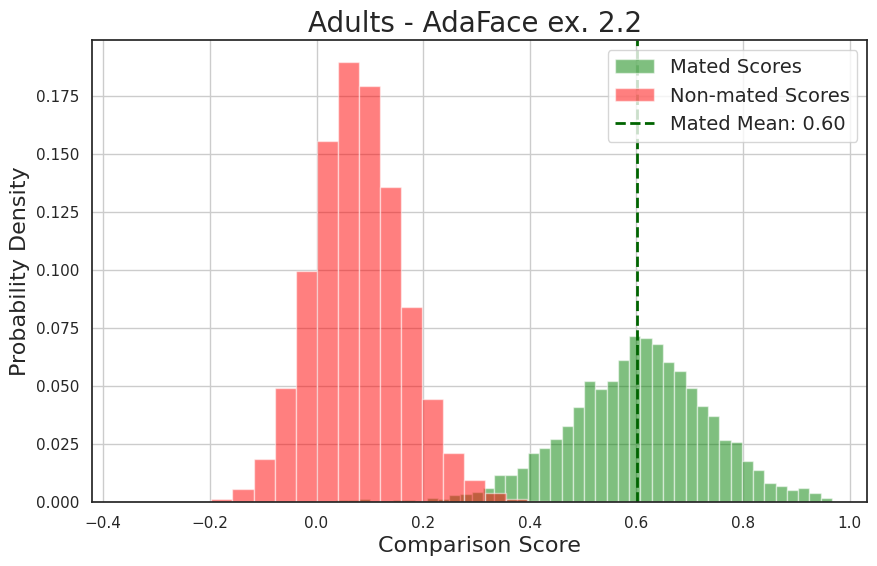

In [27]:
from DET_utils.DET_plots import *



plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Adults - AdaFace ex. 2.2 ')


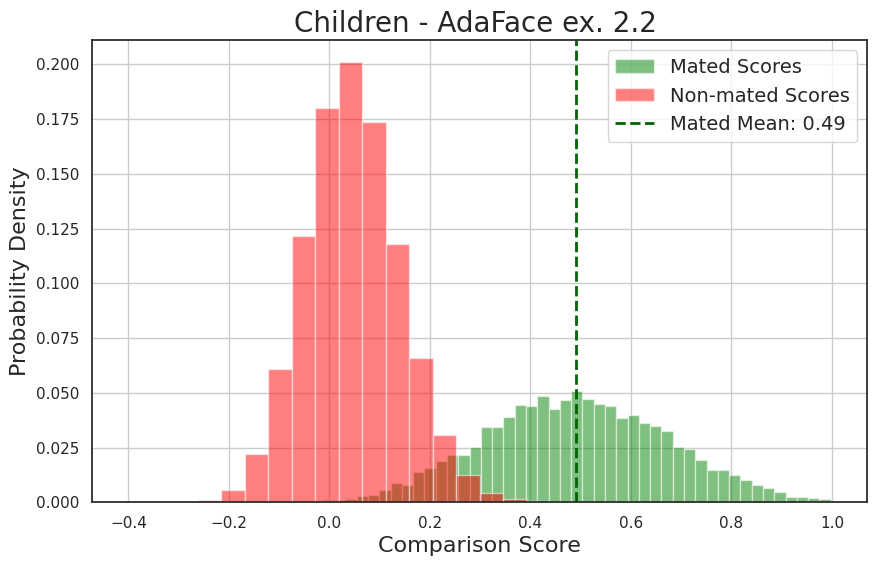

In [28]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True, title = 'Children - AdaFace ex. 2.2 ')


# DET curves


In [22]:
from DET_utils.DET_plots import *

In [23]:
# mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores1)
# nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores1)
# plt.figure(figsize=figure_size)
# plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
# plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)
# plt.xlabel("Score", size=label_fontsize)
# plt.ylabel("Probability Density", size=label_fontsize)
# plt.grid(True)
# plt.legend(loc=legend_loc, bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize)
# plt.show()

In [24]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

# d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
# print("d' canonical =", round(d_prime_system3, round_digits))


d' child = 4.59226
d' adult = 3.08504


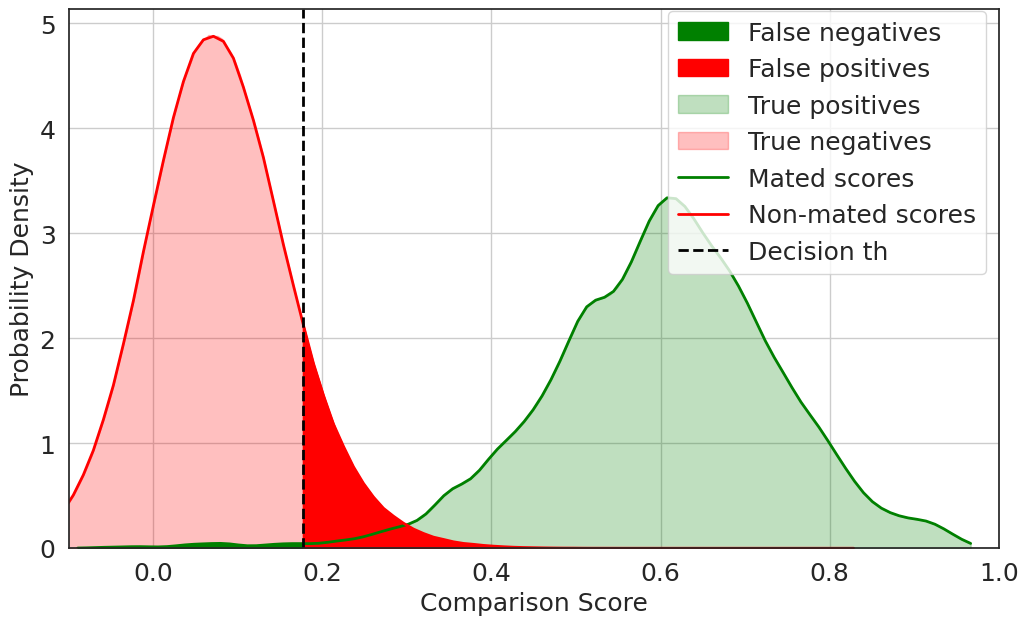

In [25]:
threshold1 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

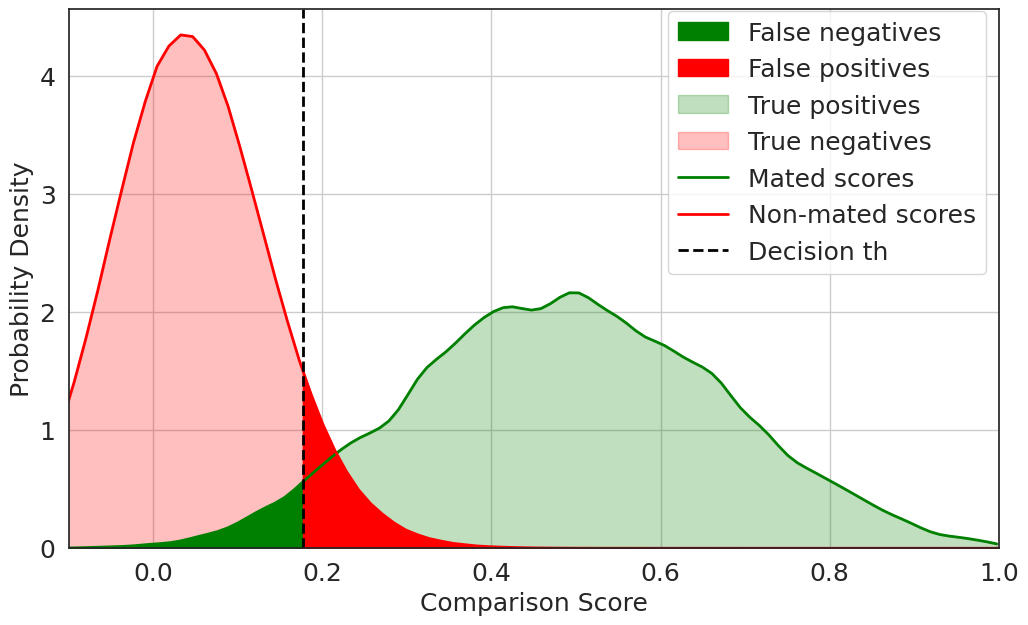

In [26]:
threshold2 = df_all_threshold_x[df_all_threshold_x.FNIR_c <0.05].Threshold.max()
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

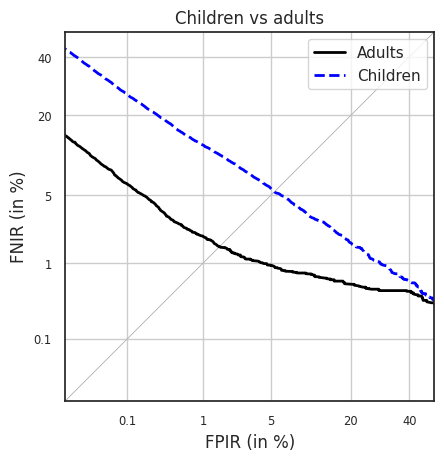

In [29]:
system_name1 = 'Adults'
system_name2 = 'Children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
det.show()